In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

from bokeh.io import output_notebook, show
output_notebook()

Python version 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Pandas version 0.19.2
Numpy version 1.11.3


Loading BokehJS ...

In [3]:
# -*- coding: utf-8 -*-

import numpy as np
from scipy import special
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.datasets import make_classification
from scipy.special import logsumexp, expit

# Используйте scipy.special для вычисления численно неустойчивых функций
# https://docs.scipy.org/doc/scipy/reference/special.html#module-scipy.special

def lossf(w, X, y, l1, l2):
    """
    Вычисление функции потерь.

    :param w: numpy.array размера  (M,) dtype = np.float
    :param X: numpy.array размера  (N, M), dtype = np.float
    :param y: numpy.array размера  (N,), dtype = np.int
    :param l1: float, l1 коэффициент регуляризатора 
    :param l2: float, l2 коэффициент регуляризатора 
    :return: float, value of loss function
    """
    lu_loss = np.sum(logsumexp(np.c_[np.zeros_like(y), np.einsum('i,ij,j->i', -y, X, w)], axis=1))
    lossf = lu_loss + l1 * np.sum(np.abs(w)) + l2 * np.dot(w, w)
    return lossf

def gradf(w, X, y, l1, l2):
    """
    Вычисление градиента функции потерь.

    :param w: numpy.array размера  (M,), dtype = np.float
    :param X: numpy.array размера  (N, M), dtype = np.float
    :param y: numpy.array размера  (N,), dtype = np.int
    :param l1: float, l1 коэффициент регуляризатора 
    :param l2: float, l2 коэффициент регуляризатора 
    :return: numpy.array размера  (M,), dtype = np.float, gradient vector d lossf / dw
    """
    gradw = np.einsum('i,i,ij->j', (expit(np.einsum('i,ij,j->i',y,X,w)) - 1), y, X) + l1*np.sign(w) + 2*l2*w
    return gradw

class LR(ClassifierMixin, BaseEstimator):
    def __init__(self, lr=1, l1=1e-4, l2=1e-4, num_iter=1000, verbose=0):
        self.l1 = l1
        self.l2 = l2
        self.w = None
        self.intercept = None
        self._w = None
        self.lr = lr
        self.verbose = verbose
        self.num_iter = num_iter

    def fit(self, X, y):
        """
        Обучение логистической регрессии.
        Настраивает self.w коэффициенты модели.

        Если self.verbose == True, то выводите значение 
        функции потерь на итерациях метода оптимизации. 

        :param X: numpy.array размера  (N, M), dtype = np.float
        :param y: numpy.array размера  (N,), dtype = np.int
        :return: self
        """
        n, d = X.shape
        X_b = np.c_[X, np.ones((n, 1))]

        self._w = 1/d * np.random.normal(scale=1/d ** 2, size=d + 1)
        self._w[-1] = 0 # bias параметр
        
        for i in range(self.num_iter):
            g = gradf(self._w, X_b, y, self.l1, self.l2)
            self._w = self._w - self.lr * g / np.sqrt(np.dot(g, g))
            if self.verbose:
                loss = lossf(self._w, X_b, y, self.l1, self.l2)
                print("Итерация {}. Значение функции потерь: {}".format(i, loss))
        
        self.w = self._w[:-1]
        self.intercept = self._w[-1]

        return self

    def predict_proba(self, X):
        """
        Предсказание вероятности принадлежности объекта к классу 1.
        Возвращает np.array размера (N,) чисел в отрезке от 0 до 1.

        :param X: numpy.array размера  (N, M), dtype = np.float
        :return: numpy.array размера  (N,), dtype = np.int
        """
        # Вычислите вероятности принадлежности каждого 
        # объекта из X к положительному классу, используйте
        # эту функцию для реализации LR.predict
        
        X_b = np.c_[X, np.ones((X.shape[0], 1))]
        probs = expit(np.dot(X_b, self._w))
        return probs

    def predict(self, X):
        """
        Предсказание класса для объекта.
        Возвращает np.array размера (N,) элементов 1 или -1.

        :param X: numpy.array размера  (N, M), dtype = np.float
        :return:  numpy.array размера  (N,), dtype = np.int
        """
        # Вычислите предсказания для каждого объекта из X
        predicts = np.where(0.5 < self.predict_proba(X), 1, -1)
        return predicts 

In [90]:
def test_work():
    print("Start test")
    X, y = make_classification(n_features=100, n_samples=1000)
    y = 2 * (y - 0.5)

    try:
        clf = LR(lr=1, l1=1e-4, l2=1e-4, num_iter=1000, verbose=0)
    except Exception:
        assert False, "Создание модели завершается с ошибкой"
        return

    try:
        clf = clf.fit(X, y)
    except Exception:
        assert False, "Обучение модели завершается с ошибкой"
        return

    assert isinstance(lossf(clf.w, X, y, 1e-3, 1e-3), float), "Функция потерь должна быть скалярной и иметь тип np.float"
    assert gradf(clf.w, X, y, 1e-3, 1e-3).shape == (100,), "Размерность градиента должна совпадать с числом параметров"
    assert gradf(clf.w, X, y, 1e-3, 1e-3).dtype == np.float, "Вектор градиента, должен состоять из элементов типа np.float"
    assert clf.predict(X).shape == (1000,), "Размер вектора предсказаний, должен совпадать с количеством объектов"
    assert np.min(clf.predict_proba(X)) >= 0, "Вероятности должны быть не меньше, чем 0"
    assert np.max(clf.predict_proba(X)) <= 1, "Вероятности должны быть не больше, чем 1"
    assert len(set(clf.predict(X))) == 2, "Метод предсказывает больше чем 2 класса на двух классовой задаче"
    print("End tests")

test_work()

Start test
End tests


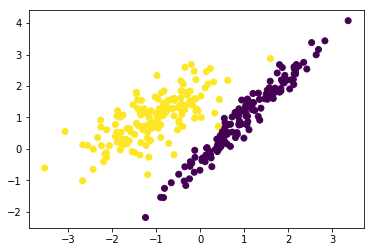

In [28]:
X1, Y1 = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(225, 2) (225,) (75, 2) (75,)


In [74]:
from sklearn.linear_model import LogisticRegression

cls = LogisticRegression(fit_intercept=True)
cls.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [75]:
y_predict = cls.predict(X_test)
print(f1_score(y_true=y_test, y_pred=y_predict), accuracy_score(y_true=y_test, y_pred=y_predict))

1.0 1.0


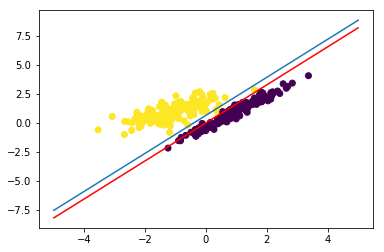

In [85]:
x = np.linspace(-5, 5)
w = cls.coef_[0]
y = -cls.intercept_/w[1] - w[0] / w[1] * x
y2 = - w[0] / w[1] * x

plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)
plt.plot(x, y)
plt.plot(x, y2, 'r')

In [86]:
y_train_ = 2 * (y_train - 0.5)
y_test_ = 2 * (y_test - 0.5)

cls = LR(lr=0.01, l1=0, l2=0, num_iter=1000, verbose=1)
cls.fit(X_train, y_train_)

Итерация 0. Значение функции потерь: 161.2948408486398
Итерация 1. Значение функции потерь: 160.12266734104526
Итерация 2. Значение функции потерь: 158.96040561667854
Итерация 3. Значение функции потерь: 157.80803098389472
Итерация 4. Значение функции потерь: 156.66551631282888
Итерация 5. Значение функции потерь: 155.53283207893006
Итерация 6. Значение функции потерь: 154.40994640974003
Итерация 7. Значение функции потерь: 153.29682513473875
Итерация 8. Значение функции потерь: 152.1934318380703
Итерация 9. Значение функции потерь: 151.09972791395268
Итерация 10. Значение функции потерь: 150.01567262457047
Итерация 11. Значение функции потерь: 148.94122316024277
Итерация 12. Значение функции потерь: 147.87633470165412
Итерация 13. Значение функции потерь: 146.82096048393498
Итерация 14. Значение функции потерь: 145.77505186237605
Итерация 15. Значение функции потерь: 144.73855837956006
Итерация 16. Значение функции потерь: 143.71142783369723
Итерация 17. Значение функции потерь: 142.6

LR(l1=0, l2=0, lr=0.01, num_iter=1000, verbose=1)

In [87]:
y_predict = cls.predict(X_test)
print(f1_score(y_true=y_test_, y_pred=y_predict), accuracy_score(y_true=y_test_, y_pred=y_predict))

1.0 1.0


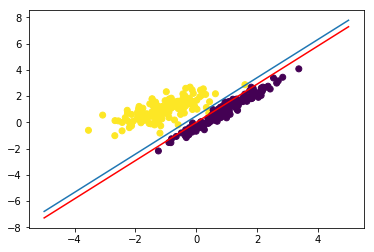

In [88]:
x = np.linspace(-5, 5)
w = cls.w
y = -cls.intercept/w[1] - w[0] / w[1] * x
y2 = - w[0] / w[1] * x

plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1)
plt.plot(x, y)
plt.plot(x, y2, 'r')